In [1]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [2]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [4]:
# SQL query

sql_by_year = """
SELECT
    wdd.year,
    sum(wft.store_weekly_sales) as total_annual_sales
FROM
    walmart_fact_table wft
JOIN
    walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
GROUP BY
    wdd.year
ORDER BY
    1
"""

sql_by_month = """
SELECT
    wdd.month,
    wdd.month_name,
    sum(wft.store_weekly_sales) as total_monthly_sales
FROM
    walmart_fact_table wft
JOIN
    walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
GROUP BY
    1,2
ORDER BY
    1
"""

sql_by_day = """
SELECT
    wdd.day,
    sum(wft.store_weekly_sales) as total_daily_sales
FROM
    walmart_fact_table wft
JOIN
    walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
GROUP BY
    1
ORDER BY
    1
"""


# Run the first query using Snowflake connector.  Once we establish
# the connector, we can reuse it for the other 2 queries
cur = conn.cursor()
cur.execute(sql_by_year)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df_by_year = pd.DataFrame(data, columns=columns)

# Next, get the monthly sales data
df_by_month = pd.read_sql(sql_by_month, conn)

# Finally, get the daily sales data
df_by_day = pd.read_sql(sql_by_day, conn)

# Force the column names to lowercase for each dataframe
df_by_year.columns = [col.lower() for col in df_by_year.columns]
df_by_month.columns = [col.lower() for col in df_by_month.columns]
df_by_day.columns = [col.lower() for col in df_by_day.columns]

print(df_by_year.columns)
print(df_by_month.columns)
print(df_by_day.columns)

/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_6243/3199554947.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_by_month = pd.read_sql(sql_by_month, conn)


Index(['year', 'total_annual_sales'], dtype='object')
Index(['month', 'month_name', 'total_monthly_sales'], dtype='object')
Index(['day', 'total_daily_sales'], dtype='object')


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_6243/3199554947.py:67: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_by_day = pd.read_sql(sql_by_day, conn)


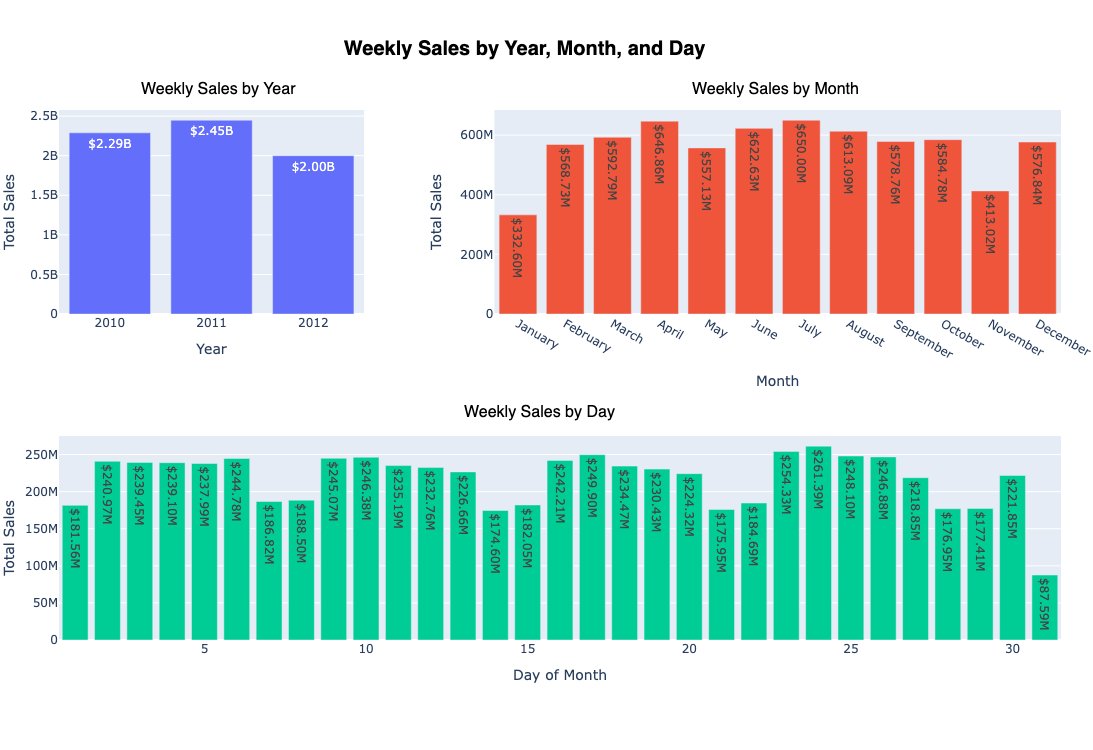

In [54]:
# Build the dashboard-type of presentation

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[
        [{'type':"xy", 't':0, 'b':0}, {"type": "xy", 't':0, 'b':0}],
        [{"type": "xy", 't':0, 'b':0, 'colspan':2}, None]
    ],
    column_widths=[0.35,0.65],
    row_heights=[0.50, 0.50],
    horizontal_spacing=0.13,  # horizontal gutter between col1 and col2
    vertical_spacing = 0.23,  # vertical spacing between the charts
)

# ==============================

# Formatting function
def formatSales(value):
    if value >= 1_000_000_000:
        return f"${value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"${value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value / 1_000:.2f}K"
    else:
        return f"${value:2f}"

# ===============================

# Total Weekly Sales - BY YEAR
trace_year = go.Bar(
    x = df_by_year['year'],
    y = df_by_year['total_annual_sales'],
    # name=f"Type {store_type}",
    orientation='v',
    text=df_by_year['total_annual_sales'].apply(formatSales),
    textposition='auto',
    hovertemplate='Year: %{x}<br>Total Annual Sales: %{y:$,.2f}<extra></extra>'
)

# Create a trace for the yearly bar chart
fig.add_trace(trace_year, row=1, col=1)

fig.add_annotation(
    text = "Weekly Sales by Year",
    x = 0.08,  # roughly center of line chart
    y = 1.06,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ===============================

# Total Weekly Sales - BY MONTH
trace_month = go.Bar(
    x = df_by_month['month_name'],
    y = df_by_month['total_monthly_sales'],
    # name=f"Type {store_type}",
    orientation='v',
    text=df_by_month['total_monthly_sales'].apply(formatSales),
    textposition='auto',
    hovertemplate='Month: %{x}<br>Total Monthly Sales: %{y:$,.2f}<extra></extra>'
)

# Create a trace for the monthly bar chart
fig.add_trace(trace_month, row=1, col=2)

fig.add_annotation(
    text = "Weekly Sales by Month",
    x = 0.8,  # roughly center of line chart
    y = 1.06,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ===============================

# Total Weekly Sales - BY DAY
trace_day = go.Bar(
    x = df_by_day['day'],
    y = df_by_day['total_daily_sales'],
    # name=f"Type {store_type}",
    orientation='v',
    text=df_by_day['total_daily_sales'].apply(formatSales),
    textposition='auto',
    hovertemplate='Day: %{x}<br>Total Daily Sales: %{y:$,.2f}<extra></extra>'
)

fig.add_trace(trace_day, row=2, col=1)

fig.add_annotation(
    text = "Weekly Sales by Day",
    x = 0.48,  # roughly center of line chart
    y = 0.43,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ================================

# Update layout
fig.update_layout(
    margin=dict(l=0, r=0, t=110, b=110),  # reduce the left/right margin a bit to help with horizontal scrolling
    height=750,
    width=1075,
    showlegend = False
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Total Sales", row=1, col=1)

fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Total Sales", row=1, col=2)

fig.update_xaxes(title_text="Day of Month", row=2, col=1)
fig.update_yaxes(title_text="Total Sales", row=2, col=1)


# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Weekly Sales by Year, Month, and Day', x=0.48, font=title_font))


fig.show()
    


In [ ]:
# Close the connection
conn.close()